# Corn Yield Prediction 

Below is is v0 of Kristin's corn yield prediction model (using 3 measurements of SIF and walk forward validation) and steps I followed:

1. Create a baseline linear model using the provided formula and treat it as benchmark. (only at national level)
2. Retrieve Data from Fused UDF-Cornucopia 
3. Implement a Random Forest model for yield prediction (at county level)
4. Perform a walk-forward validation (train/test splits by year).
5. Reserve a final holdout set to measure out-of-sample performance.


## 1. Baseline Model

Baseline model gathered data from this image (https://www.nass.usda.gov/Charts_and_Maps/Field_Crops/cornyld.php) using data previous to 2015 and removing outliers.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
    
    
#Create baseline model based on USDA Screenshot data from 1995
# Data extracted from the chart
years = np.array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014]).reshape(-1, 1)
yields = np.array([113.5, 127.1, 126.7, 134.4, 133.8, 136.9, 138.2, 129.3, 142.2, 160.3, 147.9, 150.7, 153.3, 152.6, 164.4, 146.8, 158.1, 158.1, 171.0])

# Remove outliers
q1, q3 = np.percentile(yields, [25, 75])
iqr = q3 - q1
mask = (yields >= q1 - 1.5 * iqr) & (yields <= q3 + 1.5 * iqr)
years, yields = years[mask], yields[mask]

# Fit and predict
model = LinearRegression().fit(years, yields)
yield_predictions = model.predict(years)

# Predict for 2015-2020
target_years = np.array(range(2015, 2021)).reshape(-1, 1)
predictions = model.predict(target_years)

# Calculate error for the baseline model
baseline_predictions = model.predict(years)
mse = mean_squared_error(yields, baseline_predictions)

# Create a table for predictions
data = {
    "Year": range(2015, 2021),
    "Predicted Yield (baseline)": predictions.round(2),
    "Actual Yield (USDA)": [168.4, 174.6, 176.6, 176.4, 167.5, 172.0],  # Hard-coded actual yields
    "USDA June Actual": [166.8, 168.0, 170.7, 174.0, 176.0, 178.5]  # Hard-coded USDA predictions
}
prediction_table = pd.DataFrame(data)

# Output table
print("\nPredicted Yields (2015-2020):")
print(prediction_table)


# Output model and error
print(f"Linear Model: Yield = {model.coef_[0]:.2f} * Year + {model.intercept_:.2f}")
print(f"Mean Squared Error: {mean_squared_error(yields, yield_predictions):.2f}")






Predicted Yields (2015-2020):
   Year  Predicted Yield (baseline)  Actual Yield (USDA)  USDA June Actual
0  2015                      169.84                168.4             166.8
1  2016                      172.16                174.6             168.0
2  2017                      174.49                176.6             170.7
3  2018                      176.82                176.4             174.0
4  2019                      179.14                167.5             176.0
5  2020                      181.47                172.0             178.5
Linear Model: Yield = 2.33 * Year + -4518.23
Mean Squared Error: 40.42


## 2. Retrieve Data from Fused

### Connect to Fuseda and Use Cornucopia UDF. 

We specify the area for the UDF to download data by passing a GeoDataFrame to the bbox parameter.

In [59]:
pip install fused -q

Note: you may need to restart the kernel to use updated packages.


In [60]:
# Run this cell, visit the URL, paste the provided credentials snippet in a new cell
from fused.api import NotebookCredentials
credentials = NotebookCredentials()


Please open this link to authenticate with Fused:

* [https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fwww.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=4MPeZgE47CU5M03wIEJ9jYuGm87Hd7xOK3GPKgLhru4](https://dev-tjcykxcetrz6bps6.us.auth0.com/authorize?audience=fused-python-api&scope=openid+email+name+offline_access&response_type=code&client_id=CXiwKZQmmyo0rqXZY7pzBgfsF7AL2A9l&redirect_uri=https%3A%2F%2Fwww.fused.io%2Fnotebook_login_redirect&code_challenge_method=S256&code_challenge=4MPeZgE47CU5M03wIEJ9jYuGm87Hd7xOK3GPKgLhru4)

Once you have logged in, that page will give you a code which you can paste into this notebook to finish logging in.


In [61]:
credentials.finalize(code="_eLzl1HR2p7rPZ3JsKtqkMcPScc6R--WRYpaJwFyOJbGY")

HTTPError: 403 Client Error: Forbidden for url: https://dev-tjcykxcetrz6bps6.us.auth0.com/oauth/token

In [69]:
import fused
import geopandas as gpd
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# bbox = gpd.GeoDataFrame(
#     geometry=[shapely.box(-73.9847, 40.7666, -73.9810, 40.7694)], 
#     crs=4326
# )
# bbox


### Run the Overture UDF

We may run the Fused Overture UDF with [fused.run](https://docs.fused.io/core-concepts/run/). We specify the area to load data with the bbox parameter. The UDF also provides optional parameters to select specific Overture releases, datasets, and columns - giving you flexibility to fetch only the data you need.

#### Buildings

In [107]:
df = fused.run('fsh_6zh59m43BXZwFulEbTBux4') 
df.head()


,GEOID,year,corn_sif_mean_05a,corn_sif_mean_05b,corn_sif_mean_06a,corn_sif_mean_06b,corn_sif_mean_07a,corn_sif_mean_07b,bushels_per_acre_actual,m_pct,bushels_sum_actual,geometry,area_county_acres,area_corn_acres
0,08001,2015,0.186108,0.172740,0.192047,0.150622,0.111702,0.115894,112.5,0.030000,2.567807e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,22824.954169
1,08001,2016,0.161535,0.190601,0.195189,0.164982,0.111946,0.109124,90.1,0.041667,2.856289e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,31701.325234
2,08001,2019,0.133727,0.171983,0.172547,0.150526,0.107569,0.085904,54.8,0.040000,1.667743e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,30433.272225
3,08001,2020,0.093818,0.110415,0.103081,0.069896,0.054491,0.085923,42.1,0.040000,1.281241e+06,"POLYGON ((-105.05325 39.79106, -105.05318 39.7...",7.608318e+13,30433.272225
4,08003,2016,0.007843,0.164706,0.239216,0.290196,0.466667,0.403922,0.0,0.000000,0.000000e+00,"POLYGON ((-106.03841 37.74835, -106.02912 37.7...",4.666594e+13,0.000000


In [108]:
df['year'].unique()

# Count the number of rows for each unique year
year_counts = df['year'].value_counts().sort_index()

# Display the result
print(year_counts)

year
2015    1320
2016     469
2019    1341
2020    1339
Name: count, dtype: int64


In [109]:
null_counts = df.isnull().sum()
print(null_counts)


GEOID                      0
year                       0
corn_sif_mean_05a          0
corn_sif_mean_05b          0
corn_sif_mean_06a          0
corn_sif_mean_06b          0
corn_sif_mean_07a          0
corn_sif_mean_07b          0
bushels_per_acre_actual    0
m_pct                      0
bushels_sum_actual         0
geometry                   0
area_county_acres          0
area_corn_acres            0
dtype: int64


In [110]:
# print(df.describe())

### Year by Year Walk Forward


In [111]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1) Sort your data by year
# -----------------------------
df = df.sort_values('year').reset_index(drop=True)

# We assume these are the predictive features.
features = ['corn_sif_mean_05a', 'corn_sif_mean_05b', 'corn_sif_mean_06a',
            'area_corn_acres', 'area_county_acres', 'm_pct']

target = 'bushels_per_acre_actual'

# -----------------------------
# 2) List unique years in ascending order
# -----------------------------
all_years = sorted(df['year'].unique())

# -----------------------------
# 3) Prepare data structure to save results
# -----------------------------
yearly_results = []  # Will hold per-year results
actual_predictions = []  # To store actual and predicted values for all years
pred_results = []  # To store actual and predicted values for all years


# -----------------------------
# 4) Walk-forward loop, year-by-year
# -----------------------------
# Example: If all_years = [2015, 2016, 2017, 2018, 2019, 2020],
# we start testing from the second year in the list (e.g., 2016),
# because we need at least one year to train on (2015).
for test_year in all_years[1:]:
    # 4.1) Training data = all years < test_year
    train_data = df[df['year'] < test_year]
    # 4.2) Testing data = exactly test_year
    test_data = df[df['year'] == test_year]
    
    # Skip if we don't have training or testing rows
    if train_data.empty or test_data.empty:
        continue
    
    # 4.3) Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # 4.4) Fit the model (Random Forest example)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # 4.5) Predict on the test set
    y_pred = rf.predict(X_test)
    
    # 4.6) Calculate metrics for this test_year
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # 4.7) Store the results in a list
    yearly_results.append({
        'test_year': test_year,
        'mse': mse,
        'rmse': rmse,
        'n_samples': len(test_data),
    })
        # Store actual and predicted values by year
    for actual, predicted in zip(y_test.values, y_pred):
        actual_predictions.append({
            'year': test_year,
            'actual': actual,
            'predicted': predicted

        })

# -----------------------------
# 5) Summarize results
# -----------------------------
results_df = pd.DataFrame(yearly_results)
print("Year-by-Year Results:")
print(results_df)

print("\nAverage MSE: {:.2f}".format(results_df['mse'].mean()))
print("Average RMSE: {:.2f}".format(results_df['rmse'].mean()))

actual_predictions_df = pd.DataFrame(actual_predictions)
print("\nActual vs Predicted by Year:")
print(actual_predictions_df)




Year-by-Year Results:
   test_year          mse       rmse  n_samples
0       2016  3037.627699  55.114678        469
1       2019  4731.269812  68.784226       1341
2       2020  3156.067335  56.178887       1339

Average MSE: 3641.65
Average RMSE: 60.03

Actual vs Predicted by Year:
      year  actual  predicted
0     2016   186.6    164.897
1     2016     0.0    103.237
2     2016   111.1     67.574
3     2016     0.0     24.777
4     2016   198.6    191.736
...    ...     ...        ...
3144  2020   159.6     62.716
3145  2020   101.0     85.621
3146  2020   189.1    191.149
3147  2020   175.9    186.909
3148  2020   160.9    140.231

[3149 rows x 3 columns]


Simplified Method On Bushels per Acre 

   year      actual   predicted
0  2016  132.541365  122.317051
1  2019   99.165921  107.477851
2  2020  135.759074  112.585968
Feature Importances:
                  Feature  Importance
8                   m_pct    0.394530
2       corn_sif_mean_06a    0.111171
6         area_corn_acres    0.104167
7       area_county_acres    0.086013
3  rate_of_change_05a_05b    0.078501
5  rate_of_change_05a_06a    0.068735
4  rate_of_change_05b_06a    0.064829
0       corn_sif_mean_05b    0.047358
1       corn_sif_mean_05b    0.044697


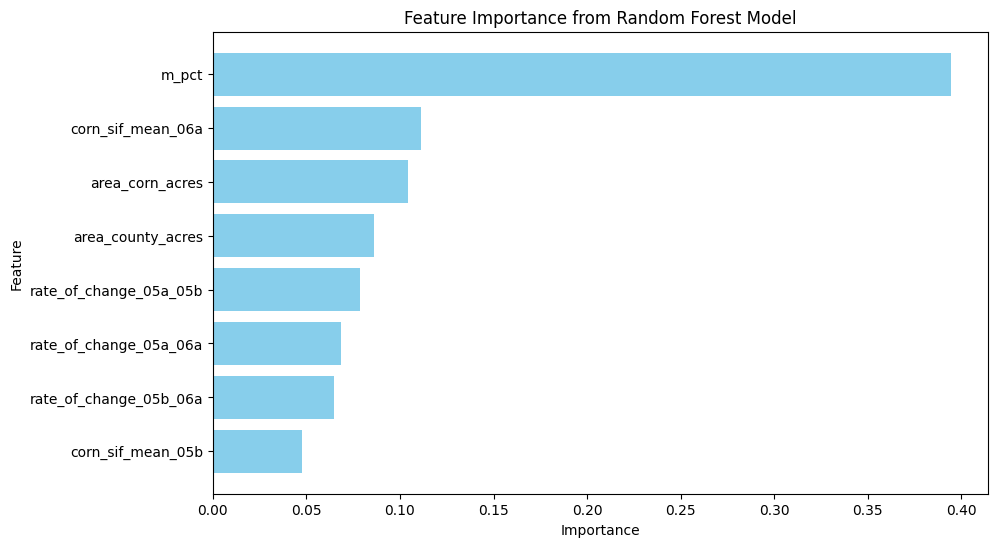

In [117]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Sort your data by year
df = df.sort_values('year').reset_index(drop=True)

# Create rate of change features
df['rate_of_change_05a_05b'] = (df['corn_sif_mean_05b'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']
df['rate_of_change_05b_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05b']) / df['corn_sif_mean_05b']
# df['rate_of_change_06a_06b'] = (df['corn_sif_mean_06b'] - df['corn_sif_mean_06a']) / df['corn_sif_mean_06a']
df['rate_of_change_05a_06a'] = (df['corn_sif_mean_06a'] - df['corn_sif_mean_05a']) / df['corn_sif_mean_05a']

# Define predictive features and target
features = ['corn_sif_mean_05b','corn_sif_mean_05b', 'corn_sif_mean_06a','rate_of_change_05a_05b',
            'rate_of_change_05b_06a', 'rate_of_change_05a_06a',
            'area_corn_acres', 'area_county_acres','m_pct']
target = 'bushels_per_acre_actual'

# List unique years in ascending order
all_years = sorted(df['year'].unique())

# Prepare data structure to save actual vs. predicted results
actual_vs_predicted = []

# Walk-forward loop, year-by-year
for test_year in all_years[1:]:
    # Training and testing data
    train_data = df[df['year'] < test_year]
    test_data = df[df['year'] == test_year]
    
    if train_data.empty or test_data.empty:
        continue

    # Define X and y
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Fit the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store actual vs. predicted results
    for actual, predicted in zip(y_test, y_pred):
        actual_vs_predicted.append({
            'year': test_year,
            'actual': actual,
            'predicted': predicted
        })

# Convert to DataFrame
actual_vs_predicted_df = pd.DataFrame(actual_vs_predicted)

# Average results by year
average_results_by_year = actual_vs_predicted_df.groupby('year').agg({
    'actual': 'mean',
    'predicted': 'mean'
}).reset_index()
average_results_by_year.head()
print(average_results_by_year)
# Feature importance
rf.fit(df[features], df[target])
feature_importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()
